In [49]:

!pip install --quiet git+https://github.com/jacobgil/pytorch-grad-cam.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [50]:
import os, gc, time, json, random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import GroupShuffleSplit

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [51]:

IMG_DIR1 = "/kaggle/input/nih-data/images_001/images"  
IMG_DIR2 = "/kaggle/input/nih-data/images_001/images"   
CSV_PATH = "/kaggle/input/nih-data/Data_Entry_2017.csv"  

OUT_DIR = Path("/kaggle/working/viT_experiment")
OUT_DIR.mkdir(parents=True, exist_ok=True)



In [52]:
df = pd.read_csv(CSV_PATH)
print("Initial rows:", len(df))
# Keep required columns from your schema
cols_expected = ["Image Index", "Finding Labels", "Patient Age", "Patient Gender", "Patient ID"]
for c in cols_expected:
    if c not in df.columns:
        raise ValueError(f"CSV missing expected column: {c}")

df = df[cols_expected].copy().dropna(subset=["Image Index", "Finding Labels", "Patient Age", "Patient Gender", "Patient ID"])
print("After dropping NA rows:", len(df))

# Normalize and clean metadata
df["Patient Gender"] = df["Patient Gender"].map({"M":"M","F":"F","Male":"M","Female":"F"})
df = df[df["Patient Gender"].isin(["M","F"])].copy()
df["gender_numeric"] = df["Patient Gender"].map({"M":0.0, "F":1.0})
df["age_norm"] = pd.to_numeric(df["Patient Age"], errors="coerce").fillna(0).clip(0,100) / 100.0

# Parse labels: convert 'No Finding' -> empty list
def parse_labels(s):
    if isinstance(s, str) and s.strip() and s.strip() != "No Finding":
        return [x.strip() for x in s.split("|") if x.strip() != ""]
    else:
        return []
df["labels_list"] = df["Finding Labels"].apply(parse_labels)

# MultiLabelBinarizer to create vector
mlb = MultiLabelBinarizer()
labels_matrix = mlb.fit_transform(df["labels_list"])
label_cols = list(mlb.classes_)
print("Detected classes:", label_cols)

df["labels_vec"] = labels_matrix.tolist()

# Build resolved image path search using both directories (best-effort)
IMG_DIRS = [Path(IMG_DIR1), Path(IMG_DIR2)]

# Index all image files once
all_image_paths = []
for d in IMG_DIRS:
    if d.exists():
        all_image_paths.extend(d.rglob("*.png"))
        all_image_paths.extend(d.rglob("*.jpg"))
        all_image_paths.extend(d.rglob("*.jpeg"))

# Dictionary: filename → full path
path_dict = {p.name: str(p) for p in all_image_paths}

# Map directly using the filename from CSV
df["img_path"] = df["Image Index"].map(path_dict)
df = df[df["img_path"].notnull()].reset_index(drop=True)
print("Rows with existing images:", len(df))


Initial rows: 112120
After dropping NA rows: 112120
Detected classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Rows with existing images: 4999


In [54]:
groups = df["Patient ID"]
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=SEED)
train_idx, temp_idx = next(gss.split(df, groups=groups))
train_df = df.iloc[train_idx].reset_index(drop=True)
temp_df  = df.iloc[temp_idx].reset_index(drop=True)
# split temp into val/test
gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=SEED)
val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df["Patient ID"]))
val_df = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)
print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))


Train/Val/Test sizes: 4005 552 442


In [55]:
IMG_SIZE = 224
BATCH_SIZE = 16   
NUM_WORKERS = 4

train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(8),
    T.ColorJitter(brightness=0.06, contrast=0.06, saturation=0.02, hue=0.01),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class NIH_Dataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transforms:
            img = self.transforms(img)
        labels = torch.tensor(row["labels_vec"], dtype=torch.float32)
        meta = torch.tensor([row["age_norm"], row["gender_numeric"]], dtype=torch.float32)
        return img, meta, labels, row["img_path"]

train_ds = NIH_Dataset(train_df, transforms=train_transforms)
val_ds   = NIH_Dataset(val_df, transforms=val_transforms)
test_ds  = NIH_Dataset(test_df, transforms=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [56]:
class ViTWithMeta(nn.Module):
    def __init__(self, vit_name='vit_base_patch16_224', num_classes=len(label_cols), meta_dim=2, pretrained=True, freeze_backbone=False):
        super().__init__()
        self.backbone = timm.create_model(vit_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feat_dim = self.backbone.num_features
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        self.meta_mlp = nn.Sequential(
            nn.Linear(meta_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim + 64, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )
    def forward(self, x, meta):
        feats = self.backbone(x)
        meta_feat = self.meta_mlp(meta)
        fused = torch.cat([feats, meta_feat], dim=1)
        logits = self.classifier(fused)
        return logits

# choose model name (if OOM on Kaggle, replace vit_base->vit_small or swin_tiny)
MODEL_NAME = "vit_base_patch16_224"  # change to 'vit_small_patch16_224' if memory limited
model = ViTWithMeta(vit_name=MODEL_NAME, num_classes=len(label_cols), meta_dim=2, pretrained=True, freeze_backbone=False)
model = model.to(device)
print("Model parameter count (M):", sum(p.numel() for p in model.parameters())/1e6)


Model parameter count (M): 86.016334


In [57]:
class BCEFocal(nn.Module):
    def __init__(self, gamma=1.5, reduction='mean'):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        p_t = targets * probs + (1 - targets) * (1 - probs)
        focal_scale = (1 - p_t) ** self.gamma
        loss = focal_scale * bce_loss
        return loss.mean() if self.reduction=='mean' else loss.sum()

criterion = BCEFocal(gamma=1.5).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [59]:
def compute_aucs(y_true, y_prob):
    ncls = y_true.shape[1]
    per_cls = []
    for i in range(ncls):
        try:
            per_cls.append(roc_auc_score(y_true[:, i], y_prob[:, i]))
        except Exception:
            per_cls.append(np.nan)
    try:
        micro = roc_auc_score(y_true.ravel(), y_prob.ravel())
    except Exception:
        micro = np.nan
    macro = np.nanmean(per_cls)
    return per_cls, micro, macro

def eval_model(model, loader):
    model.eval()
    all_targets, all_probs = [], []
    total_loss, n = 0.0, 0
    with torch.no_grad():
        for imgs, meta, labels, _ in loader:
            imgs = imgs.to(device); meta = meta.to(device); labels = labels.to(device)
            logits = model(imgs, meta)
            loss = criterion(logits, labels)
            total_loss += float(loss.item()) * imgs.size(0)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            all_probs.append(probs); all_targets.append(labels.detach().cpu().numpy())
            n += imgs.size(0)
    all_probs = np.vstack(all_probs); all_targets = np.vstack(all_targets)
    avg_loss = total_loss / n
    per_cls, micro, macro = compute_aucs(all_targets, all_probs)
    return avg_loss, per_cls, micro, macro, all_targets, all_probs


In [60]:
from tqdm.auto import tqdm
EPOCHS = 55 
best_micro = 0.0
history = defaultdict(list)
ckpt_path = str(OUT_DIR / "vit_meta_best.pth")

for epoch in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    train_loss, n = 0.0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for imgs, meta, labels, _ in loop:
        imgs = imgs.to(device); meta = meta.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs, meta)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += float(loss.item()) * imgs.size(0)
        n += imgs.size(0)
    train_loss = train_loss / n

    val_loss, val_per_cls, val_micro, val_macro, val_t, val_p = eval_model(model, val_loader)
    scheduler.step(val_micro)
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['val_micro_auc'].append(val_micro); history['val_macro_auc'].append(val_macro)
    history['val_per_class_auc'].append(val_per_cls)
    print(f"Epoch {epoch} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_micro={val_micro:.4f} val_macro={val_macro:.4f} time={(time.time()-t0):.1f}s")

    if val_micro > best_micro:
        best_micro = val_micro
        torch.save({'model_state': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'history': history}, ckpt_path)
        print("Saved best checkpoint:", ckpt_path)


Epoch 1/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1 | train_loss=0.2478 val_loss=0.2077 val_micro=0.5431 val_macro=0.5150 time=86.5s
Saved best checkpoint: /kaggle/working/viT_experiment/vit_meta_best.pth


Epoch 2/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2 | train_loss=0.1836 val_loss=0.1332 val_micro=0.4951 val_macro=0.5740 time=87.0s


Epoch 3/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3 | train_loss=0.1161 val_loss=0.0903 val_micro=0.7453 val_macro=0.5856 time=87.6s
Saved best checkpoint: /kaggle/working/viT_experiment/vit_meta_best.pth


Epoch 4/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4 | train_loss=0.0826 val_loss=0.0757 val_micro=0.6727 val_macro=0.6090 time=87.3s


Epoch 5/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5 | train_loss=0.0712 val_loss=0.0708 val_micro=0.7658 val_macro=0.6269 time=87.9s
Saved best checkpoint: /kaggle/working/viT_experiment/vit_meta_best.pth


Epoch 6/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 6 | train_loss=0.0679 val_loss=0.1509 val_micro=0.7150 val_macro=0.6291 time=87.6s


Epoch 7/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 7 | train_loss=0.0709 val_loss=2.7620 val_micro=0.3618 val_macro=0.5817 time=87.6s


Epoch 8/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0><function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>^

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>        
self._shutdown_workers()self._shutdown_workers()Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>  File "/usr/local/lib/python3.11/dist-packages/tor

Epoch 8 | train_loss=0.0721 val_loss=0.0734 val_micro=0.7330 val_macro=0.5552 time=89.0s


Epoch 9/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9 | train_loss=0.0711 val_loss=0.0732 val_micro=0.7250 val_macro=0.5702 time=87.6s


Epoch 10/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.0715 val_loss=0.0754 val_micro=0.7055 val_macro=0.5429 time=87.6s


Epoch 11/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 11 | train_loss=0.0701 val_loss=0.0722 val_micro=0.7450 val_macro=0.6053 time=87.7s


Epoch 12/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^^self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    
if w.is_alive():A

Epoch 12 | train_loss=0.0697 val_loss=0.0722 val_micro=0.7377 val_macro=0.5885 time=87.7s


Epoch 13/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()    
Exception ignored in: if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>

     Traceback (most recent call last):
 if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618,

Epoch 13 | train_loss=0.0693 val_loss=0.0723 val_micro=0.7391 val_macro=0.5881 time=88.8s


Epoch 14/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 14 | train_loss=0.0686 val_loss=0.0722 val_micro=0.7441 val_macro=0.5941 time=87.6s


Epoch 15/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.0698 val_loss=0.0715 val_micro=0.7446 val_macro=0.5937 time=87.8s


Epoch 16/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 16 | train_loss=0.0694 val_loss=0.0712 val_micro=0.7505 val_macro=0.6018 time=87.9s


Epoch 17/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 17 | train_loss=0.0685 val_loss=0.0719 val_micro=0.7414 val_macro=0.5878 time=88.1s


Epoch 18/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

^      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():
              ^ ^ ^^^  ^^^^^^^^^^^
^  File 

Epoch 18 | train_loss=0.0688 val_loss=0.0713 val_micro=0.7486 val_macro=0.5981 time=90.4s


Epoch 19/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 19 | train_loss=0.0682 val_loss=0.0714 val_micro=0.7506 val_macro=0.5991 time=88.0s


Epoch 20/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 20 | train_loss=0.0686 val_loss=0.0721 val_micro=0.7432 val_macro=0.5888 time=87.7s


Epoch 21/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 21 | train_loss=0.0684 val_loss=0.0714 val_micro=0.7496 val_macro=0.5938 time=87.7s


Epoch 22/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 22 | train_loss=0.0682 val_loss=0.0715 val_micro=0.7513 val_macro=0.6001 time=87.5s


Epoch 23/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 23 | train_loss=0.0681 val_loss=0.0711 val_micro=0.7516 val_macro=0.5993 time=88.6s


Epoch 24/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 24 | train_loss=0.0680 val_loss=0.0709 val_micro=0.7553 val_macro=0.6022 time=87.7s


Epoch 25/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 25 | train_loss=0.0685 val_loss=0.0717 val_micro=0.7459 val_macro=0.5925 time=87.8s


Epoch 26/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 26 | train_loss=0.0680 val_loss=0.0712 val_micro=0.7519 val_macro=0.5996 time=87.8s


Epoch 27/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 27 | train_loss=0.0673 val_loss=0.0714 val_micro=0.7505 val_macro=0.5971 time=87.6s


Epoch 28/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 28 | train_loss=0.0674 val_loss=0.0714 val_micro=0.7518 val_macro=0.5984 time=87.7s


Epoch 29/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0><function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive(): 
       ^  ^^^ ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/usr/lib/pytho

Epoch 29 | train_loss=0.0683 val_loss=0.0707 val_micro=0.7579 val_macro=0.6081 time=89.0s


Epoch 30/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 30 | train_loss=0.0683 val_loss=0.0711 val_micro=0.7534 val_macro=0.6018 time=87.7s


Epoch 31/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 31 | train_loss=0.0677 val_loss=0.0714 val_micro=0.7497 val_macro=0.5979 time=87.5s


Epoch 32/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 32 | train_loss=0.0685 val_loss=0.0715 val_micro=0.7493 val_macro=0.5971 time=87.8s


Epoch 33/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 33 | train_loss=0.0678 val_loss=0.0715 val_micro=0.7494 val_macro=0.5980 time=87.8s


Epoch 34/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
 
           ^ ^ ^^ ^ ^^  ^^^^^^^^^^
^  File

Epoch 34 | train_loss=0.0684 val_loss=0.0711 val_micro=0.7550 val_macro=0.6035 time=89.0s


Epoch 35/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 35 | train_loss=0.0682 val_loss=0.0709 val_micro=0.7548 val_macro=0.6021 time=87.7s


Epoch 36/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 36 | train_loss=0.0677 val_loss=0.0887 val_micro=0.7413 val_macro=0.5982 time=87.5s


Epoch 37/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 37 | train_loss=0.0681 val_loss=0.0712 val_micro=0.7499 val_macro=0.5972 time=87.8s


Epoch 38/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 38 | train_loss=0.0680 val_loss=0.0712 val_micro=0.7521 val_macro=0.6032 time=87.6s


Epoch 39/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive(): 
         ^ ^ ^^^^^^^Exception ignored in: ^^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>^^
^^^^Traceback (most recent call last):

^  File "/usr/local/lib/python3.11/dist-packages/torch/ut

Epoch 39 | train_loss=0.0680 val_loss=0.0712 val_micro=0.7517 val_macro=0.5984 time=89.5s


Epoch 40/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 40 | train_loss=0.0680 val_loss=0.0710 val_micro=0.7562 val_macro=0.6036 time=87.7s


Epoch 41/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 41 | train_loss=0.0680 val_loss=0.0710 val_micro=0.7537 val_macro=0.5993 time=87.9s


Epoch 42/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 42 | train_loss=0.0684 val_loss=0.0713 val_micro=0.7522 val_macro=0.5986 time=87.9s


Epoch 43/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
      ^ ^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 43 | train_loss=0.0679 val_loss=0.0710 val_micro=0.7577 val_macro=0.6013 time=87.9s


Epoch 44/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    

Epoch 44 | train_loss=0.0675 val_loss=0.0713 val_micro=0.7524 val_macro=0.5981 time=89.1s


Epoch 45/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 45 | train_loss=0.0678 val_loss=0.0709 val_micro=0.7559 val_macro=0.6038 time=88.4s


Epoch 46/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 46 | train_loss=0.0682 val_loss=0.0711 val_micro=0.7538 val_macro=0.5993 time=87.8s


Epoch 47/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 47 | train_loss=0.0677 val_loss=0.0714 val_micro=0.7510 val_macro=0.5970 time=87.9s


Epoch 48/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 48 | train_loss=0.0680 val_loss=0.0710 val_micro=0.7532 val_macro=0.5996 time=87.9s


Epoch 49/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 49 | train_loss=0.0678 val_loss=0.0710 val_micro=0.7534 val_macro=0.5972 time=88.9s


Epoch 50/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 50 | train_loss=0.0680 val_loss=0.0711 val_micro=0.7509 val_macro=0.5984 time=87.7s


Epoch 51/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 51 | train_loss=0.0682 val_loss=0.0711 val_micro=0.7552 val_macro=0.6015 time=87.9s


Epoch 52/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 52 | train_loss=0.0680 val_loss=0.0713 val_micro=0.7516 val_macro=0.5989 time=87.9s


Epoch 53/55:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 53 | train_loss=0.0680 val_loss=0.0718 val_micro=0.7481 val_macro=0.5959 time=88.0s


Epoch 54/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 54 | train_loss=0.0677 val_loss=0.0712 val_micro=0.7515 val_macro=0.5983 time=87.8s


Epoch 55/55:   0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7838292a9bc0>^
^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():  
          ^ ^^ ^ ^^^^^^^^^^^^Exception

Epoch 55 | train_loss=0.0683 val_loss=0.0710 val_micro=0.7523 val_macro=0.6018 time=90.2s


In [68]:

if os.path.exists(ckpt_path):
    ck = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(ck['model_state'])
    print("Loaded checkpoint epoch:", ck.get('epoch'))
    history = ck.get('history', {})  # load training history too


test_loss, test_per_cls, test_micro, test_macro, test_targets, test_probs = eval_model(model, test_loader)
print("Test loss:", test_loss, "Test micro AUC:", test_micro, "Test macro AUC:", test_macro)

# Save per-class AUCs
pd.DataFrame({"disease": label_cols, "auc": test_per_cls}).sort_values("auc").to_csv(OUT_DIR/"per_class_auc_test.csv", index=False)
print("Saved per-class AUC ->", OUT_DIR/"per_class_auc_test.csv")


Loaded checkpoint epoch: 5
Test loss: 0.07032610179342295 Test micro AUC: 0.7474949910535397 Test macro AUC: 0.6592354609670932
Saved per-class AUC -> /kaggle/working/viT_experiment/per_class_auc_test.csv


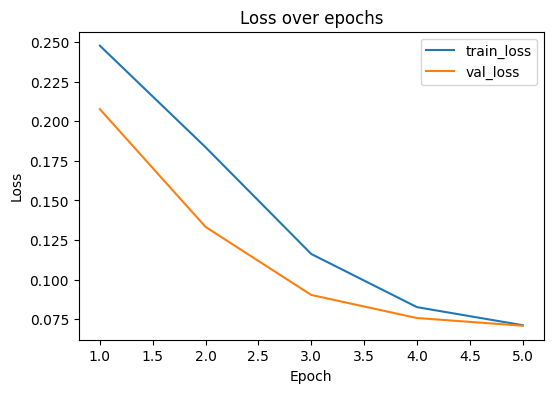

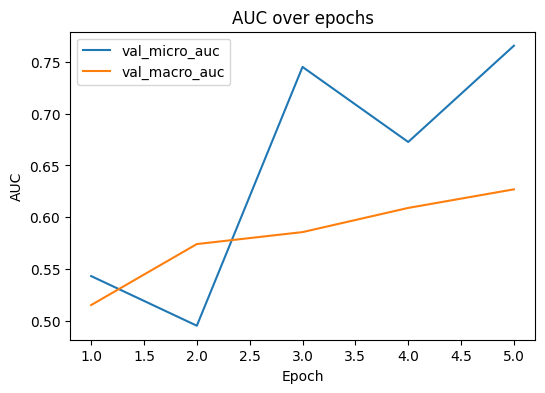

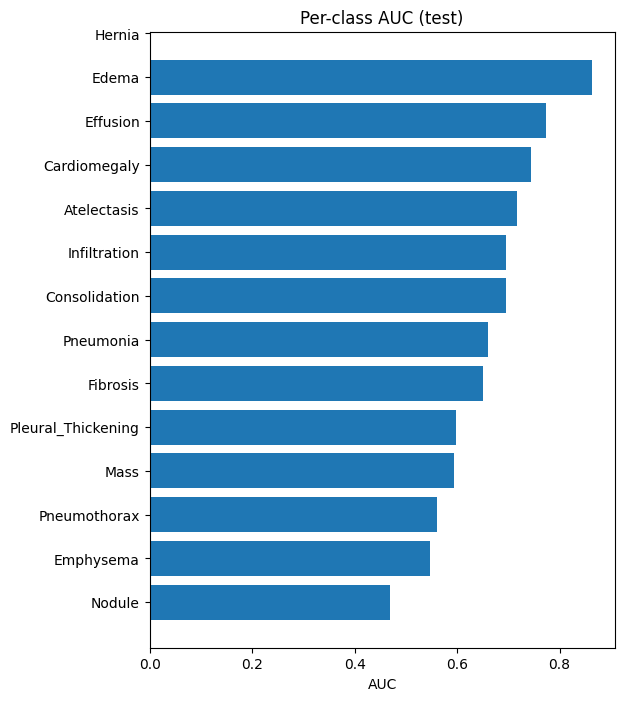

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


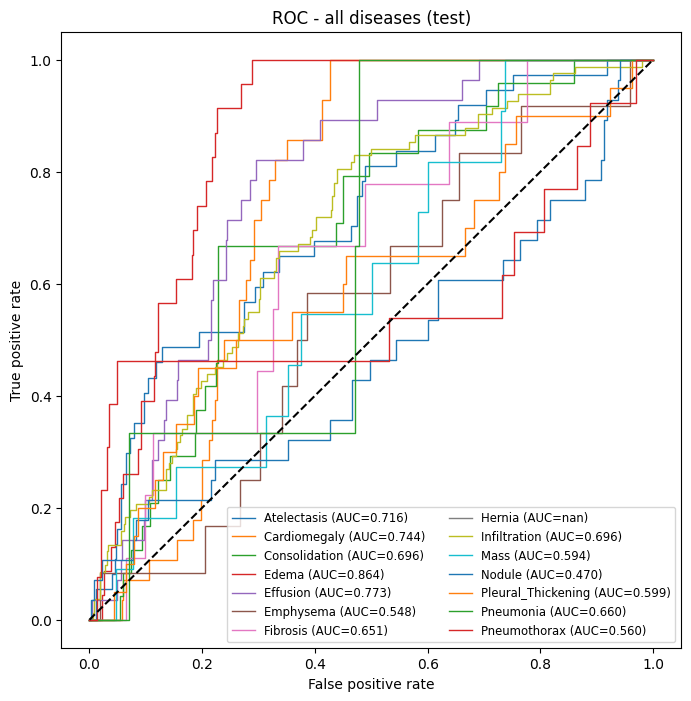

Saved classification report -> /kaggle/working/viT_experiment/classification_report_test.csv
               precision  recall  f1-score  support
Atelectasis          0.0     0.0       0.0     37.0
Cardiomegaly         0.0     0.0       0.0     28.0
Consolidation        0.0     0.0       0.0     24.0
Edema                0.0     0.0       0.0     23.0
Effusion             0.0     0.0       0.0     28.0
Saved example images to /kaggle/working/viT_experiment


In [69]:
# 1) Loss curve (train vs val)
plt.figure(figsize=(6,4))
plt.plot(range(1,len(history['train_loss'])+1), history['train_loss'], label='train_loss')
plt.plot(range(1,len(history['val_loss'])+1), history['val_loss'], label='val_loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss over epochs"); plt.legend()
plt.savefig(OUT_DIR/"loss_curve.png"); plt.show()

# 2) Micro + Macro AUC over epochs
plt.figure(figsize=(6,4))
plt.plot(range(1,len(history['val_micro_auc'])+1), history['val_micro_auc'], label='val_micro_auc')
plt.plot(range(1,len(history['val_macro_auc'])+1), history['val_macro_auc'], label='val_macro_auc')
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("AUC over epochs"); plt.legend()
plt.savefig(OUT_DIR/"auc_curve.png"); plt.show()

# 3) Per-class AUC bar (test)
per_class_df = pd.DataFrame({"disease": label_cols, "auc": test_per_cls})
per_class_df = per_class_df.sort_values("auc")
plt.figure(figsize=(6,8))
plt.barh(per_class_df['disease'], per_class_df['auc'])
plt.xlabel("AUC"); plt.title("Per-class AUC (test)")
plt.savefig(OUT_DIR/"per_class_auc_test.png"); plt.show()

# 4) All-in-one ROC plot (test) - overlay many curves
plt.figure(figsize=(8,8))
for i, lab in enumerate(label_cols):
    try:
        fpr, tpr, _ = roc_curve(test_targets[:, i], test_probs[:, i])
        plt.plot(fpr, tpr, linewidth=1, label=f'{lab} (AUC={test_per_cls[i]:.3f})')
    except Exception:
        pass
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False positive rate"); plt.ylabel("True positive rate"); plt.title("ROC - all diseases (test)")
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.savefig(OUT_DIR/"roc_all_test.png"); plt.show()

# 5) Classification report (table)
y_pred = (test_probs >= 0.5).astype(int)
cr = classification_report(test_targets, y_pred, target_names=label_cols, output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr).T
cr_df.to_csv(OUT_DIR/"classification_report_test.csv")
print("Saved classification report ->", OUT_DIR/"classification_report_test.csv")
print(cr_df.head())

# 6) Example image + attention overlay (call further cell for rollout)
# We'll save a few example images to OUT_DIR for manual inspection
for i in range(min(6, len(test_ds))):
    img, meta, labels, path = test_ds[i]
    # save normalized image
    img_np = (img.permute(1,2,0).numpy() * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
    img_np = np.clip(img_np, 0, 1)
    plt.imsave(OUT_DIR/f"example_{i}.png", img_np)
print("Saved example images to", OUT_DIR)


In [71]:
per_class_df = pd.DataFrame({"disease": label_cols, "auc": test_per_cls})
per_class_df = per_class_df.sort_values("auc", ascending=False)
print("Per-class AUC:")
print(per_class_df)

Per-class AUC:
               disease       auc
3                Edema  0.864066
4             Effusion  0.772516
1         Cardiomegaly  0.743961
0          Atelectasis  0.716383
8         Infiltration  0.696037
2        Consolidation  0.695774
12           Pneumonia  0.659833
6             Fibrosis  0.651270
11  Pleural_Thickening  0.598578
9                 Mass  0.593546
13        Pneumothorax  0.560337
5            Emphysema  0.547868
10              Nodule  0.469893
7               Hernia       NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
